## Loan Approval Prediction

### Required Libraries

In [1]:
# importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
import warnings
warnings.filterwarnings('ignore')

### Dataset Loading and Preview

In [2]:
# dataset
file_path = 'loan_data.csv'
df = pd.read_csv(file_path)

df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
1,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
2,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
3,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
4,LP001013,Male,Yes,0,Not Graduate,No,2333,1516.0,95.0,360.0,1.0,Urban,Y


### Data Cleaning and Preprocessing

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381 entries, 0 to 380
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            381 non-null    object 
 1   Gender             376 non-null    object 
 2   Married            381 non-null    object 
 3   Dependents         373 non-null    object 
 4   Education          381 non-null    object 
 5   Self_Employed      360 non-null    object 
 6   ApplicantIncome    381 non-null    int64  
 7   CoapplicantIncome  381 non-null    float64
 8   LoanAmount         381 non-null    float64
 9   Loan_Amount_Term   370 non-null    float64
 10  Credit_History     351 non-null    float64
 11  Property_Area      381 non-null    object 
 12  Loan_Status        381 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 38.8+ KB


In [4]:
# cecking for null values
print("Null values in the dataset:")
print(df.isnull().sum())

Null values in the dataset:
Loan_ID               0
Gender                5
Married               0
Dependents            8
Education             0
Self_Employed        21
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            0
Loan_Amount_Term     11
Credit_History       30
Property_Area         0
Loan_Status           0
dtype: int64


In [5]:
# rows with null values dropped
df.dropna(inplace=True)

print("\nAfter dropping null values:")
print(df.isnull().sum())


After dropping null values:
Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64


### Exploratory Data Analysis (EDA)

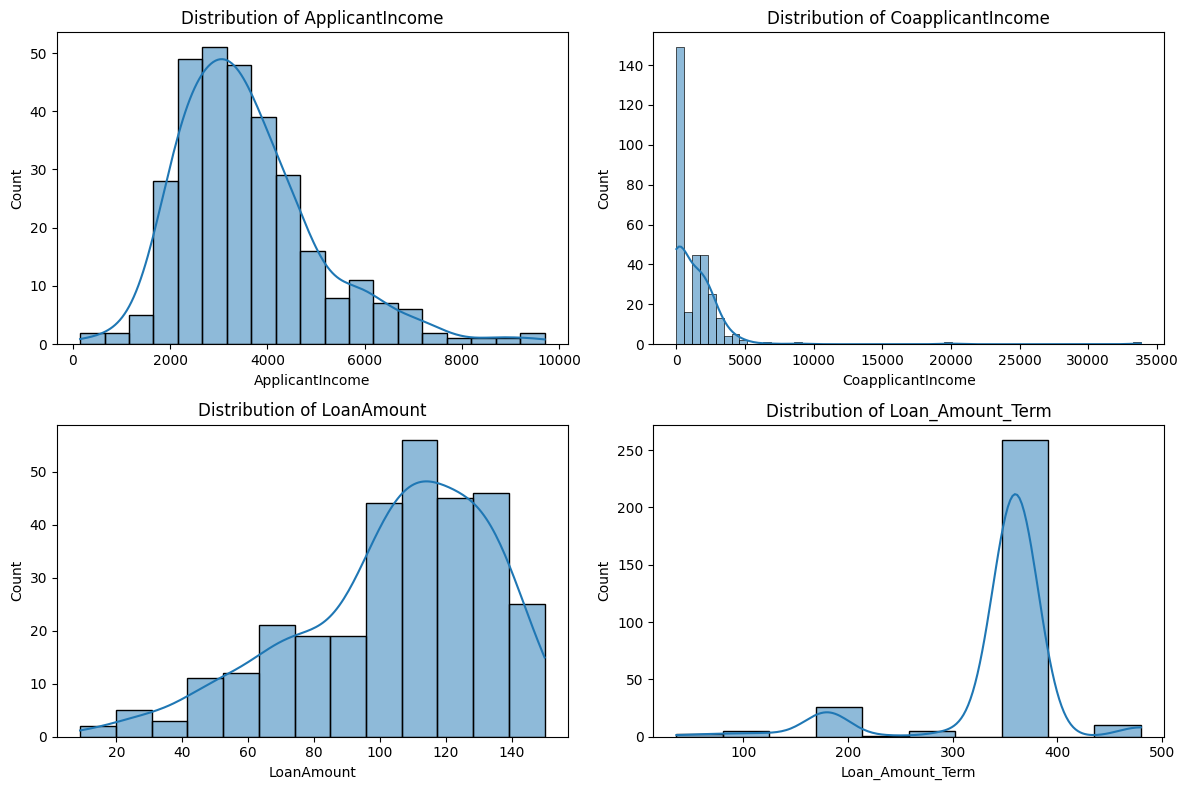

In [6]:
# Univariate Analysis
# Numerical Variables
num_vars = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']
plt.figure(figsize=(12, 8))
for i, var in enumerate(num_vars, 1):
    plt.subplot(2, 2, i)
    sns.histplot(df[var], kde=True)
    plt.title(f'Distribution of {var}')
plt.tight_layout()
plt.show()

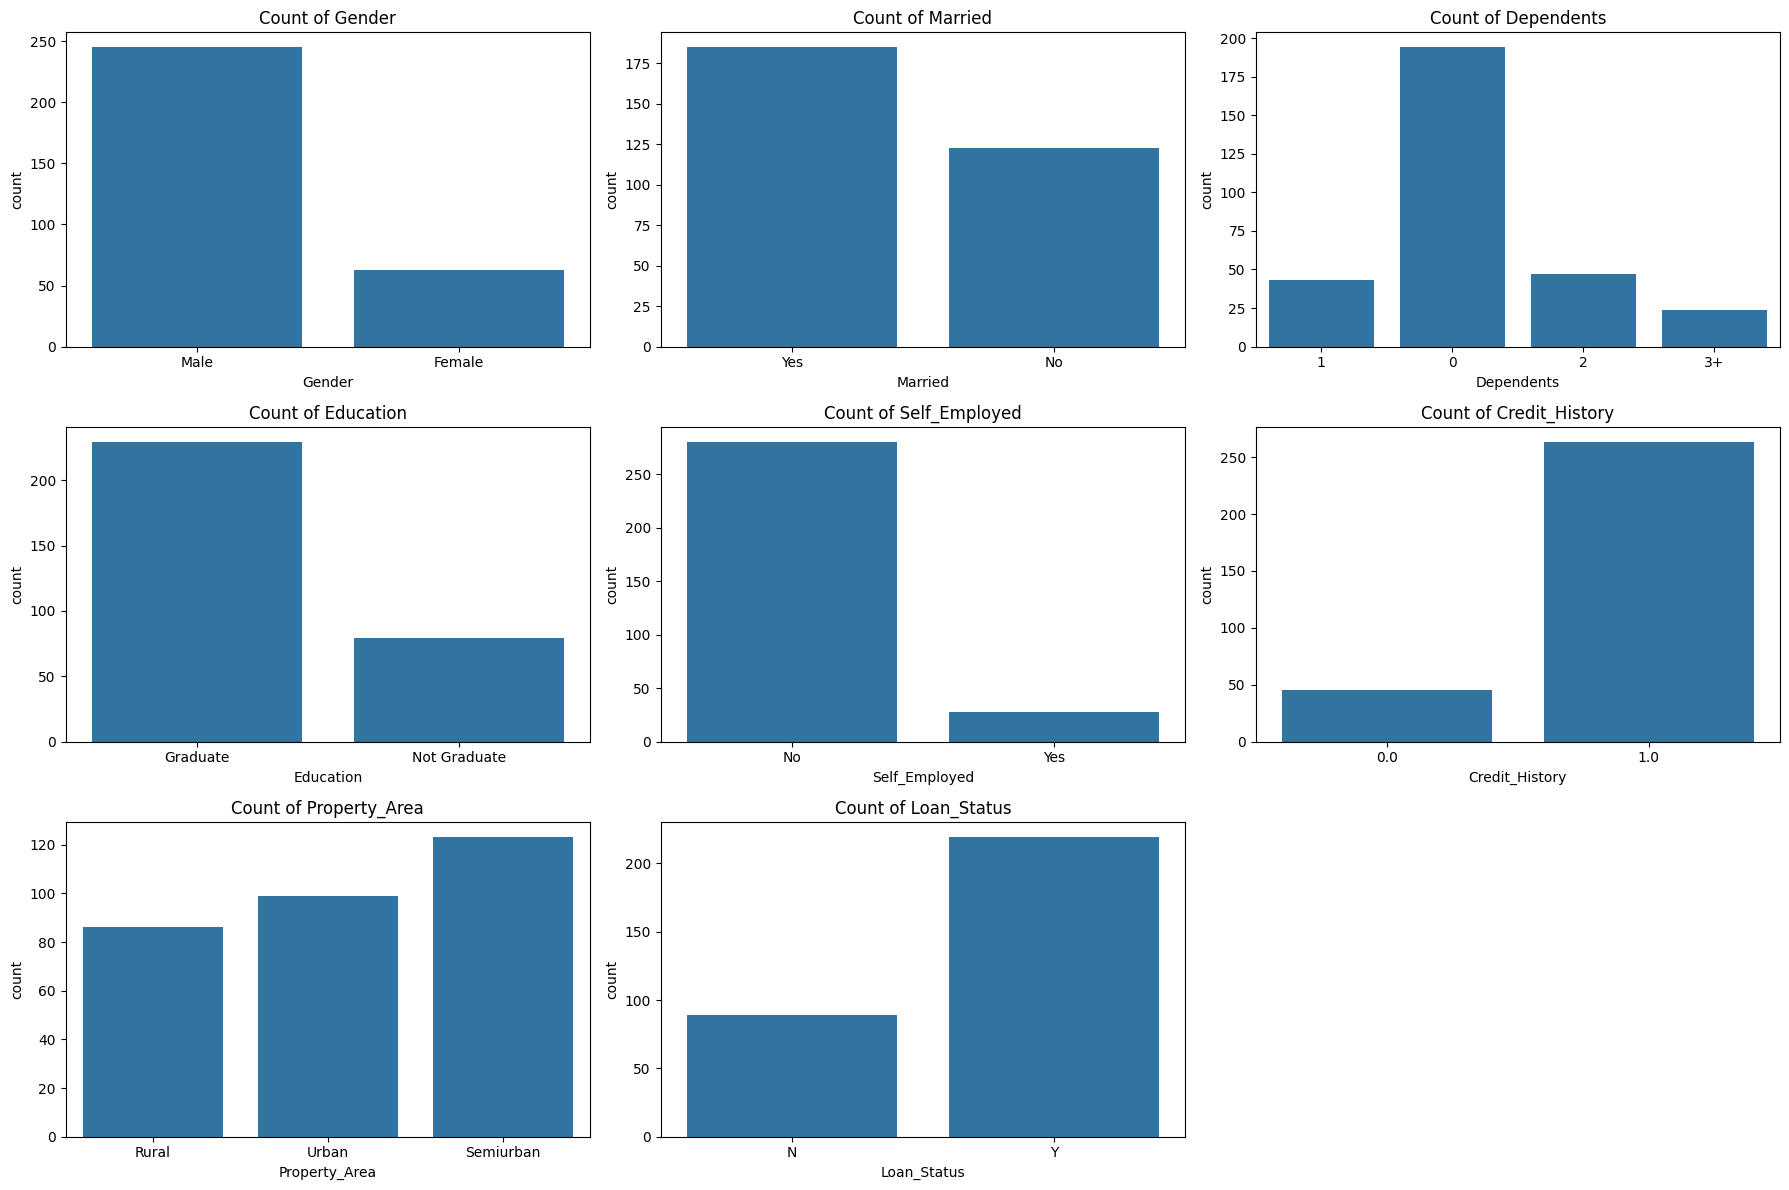

In [7]:
# Categorical Variables
cat_vars = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Credit_History', 'Property_Area', 'Loan_Status']
plt.figure(figsize=(18, 12))
for i, var in enumerate(cat_vars, 1):
    plt.subplot(3, 3, i)
    sns.countplot(data=df, x=var)
    plt.title(f'Count of {var}')
plt.tight_layout()
plt.show()

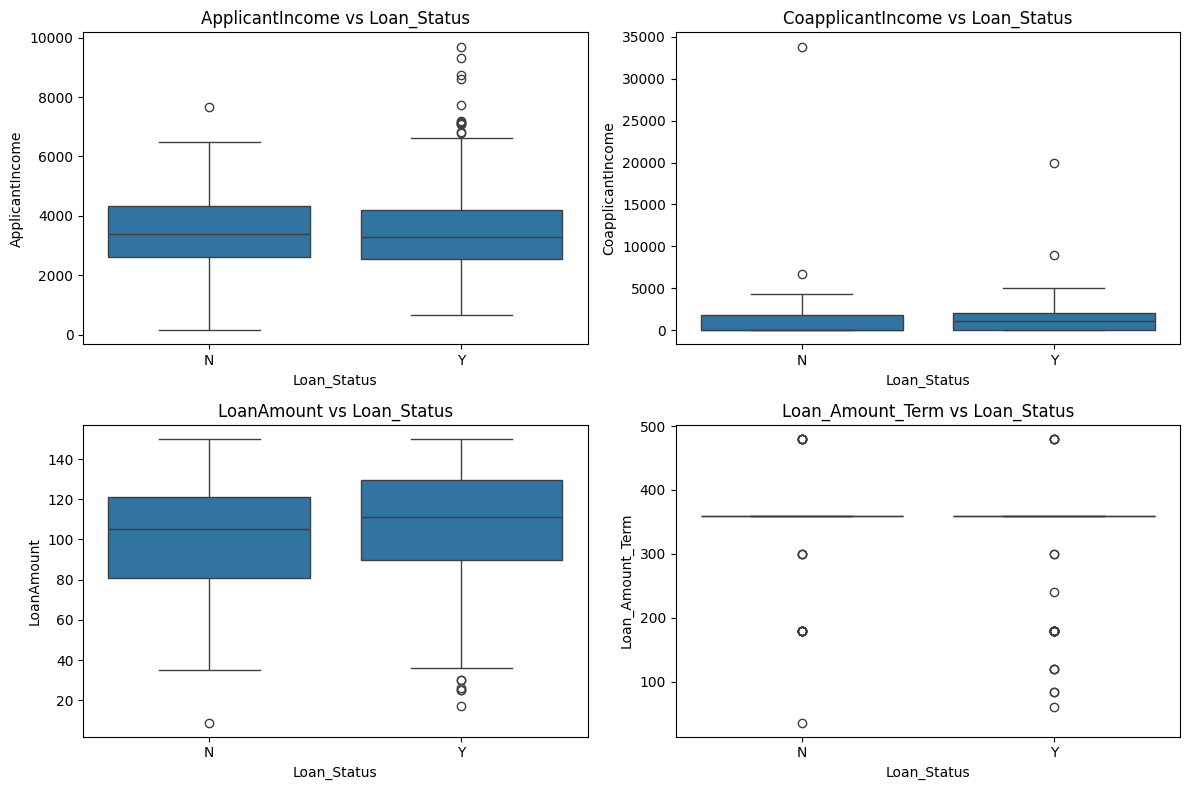

In [8]:
# Bivariate Analysis
# Relationship between numerical variables and Loan_Status
plt.figure(figsize=(12, 8))
for i, var in enumerate(num_vars, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(data=df, x='Loan_Status', y=var)
    plt.title(f'{var} vs Loan_Status')
plt.tight_layout()
plt.show()

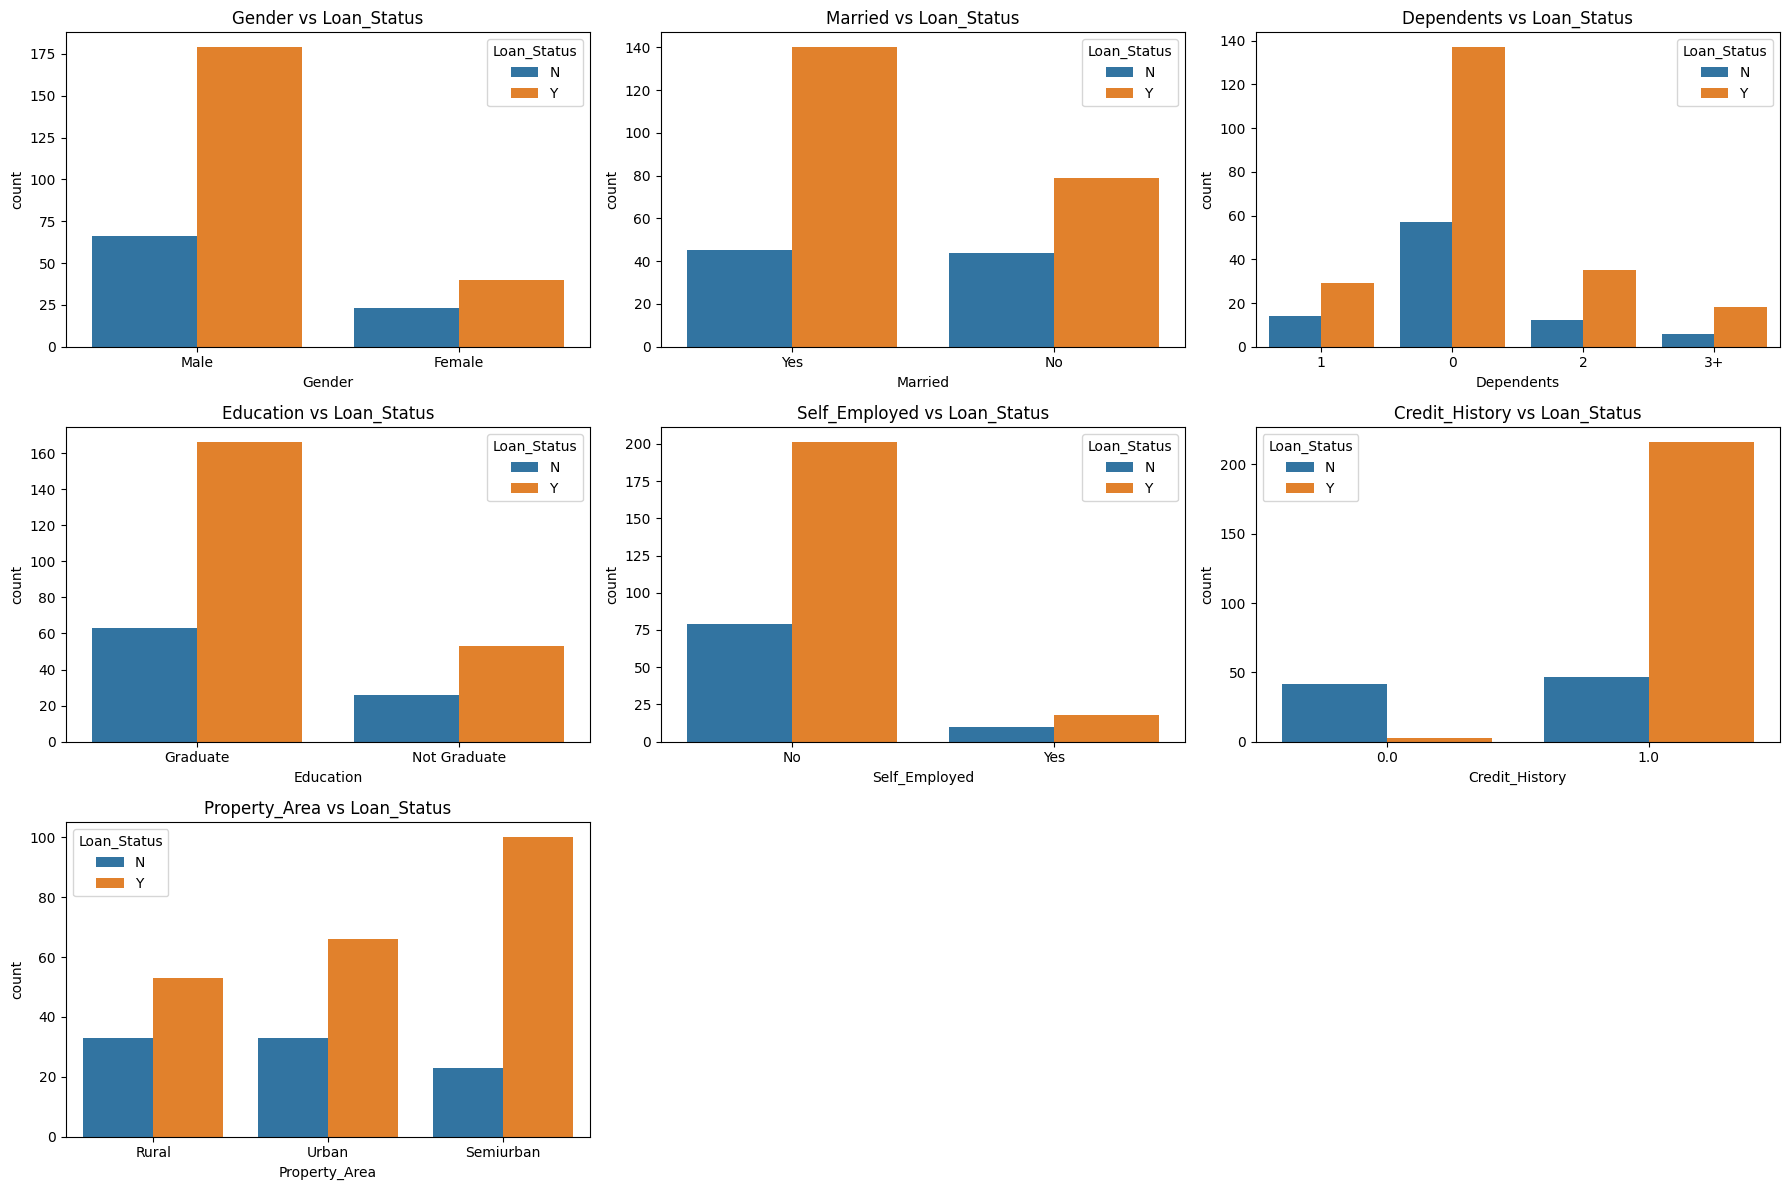

In [9]:
# r/s between categorical variables and Loan_Status
plt.figure(figsize=(18, 12))
for i, var in enumerate(cat_vars[:-1], 1):
    plt.subplot(3, 3, i)
    sns.countplot(data=df, x=var, hue='Loan_Status')
    plt.title(f'{var} vs Loan_Status')
plt.tight_layout()
plt.show()

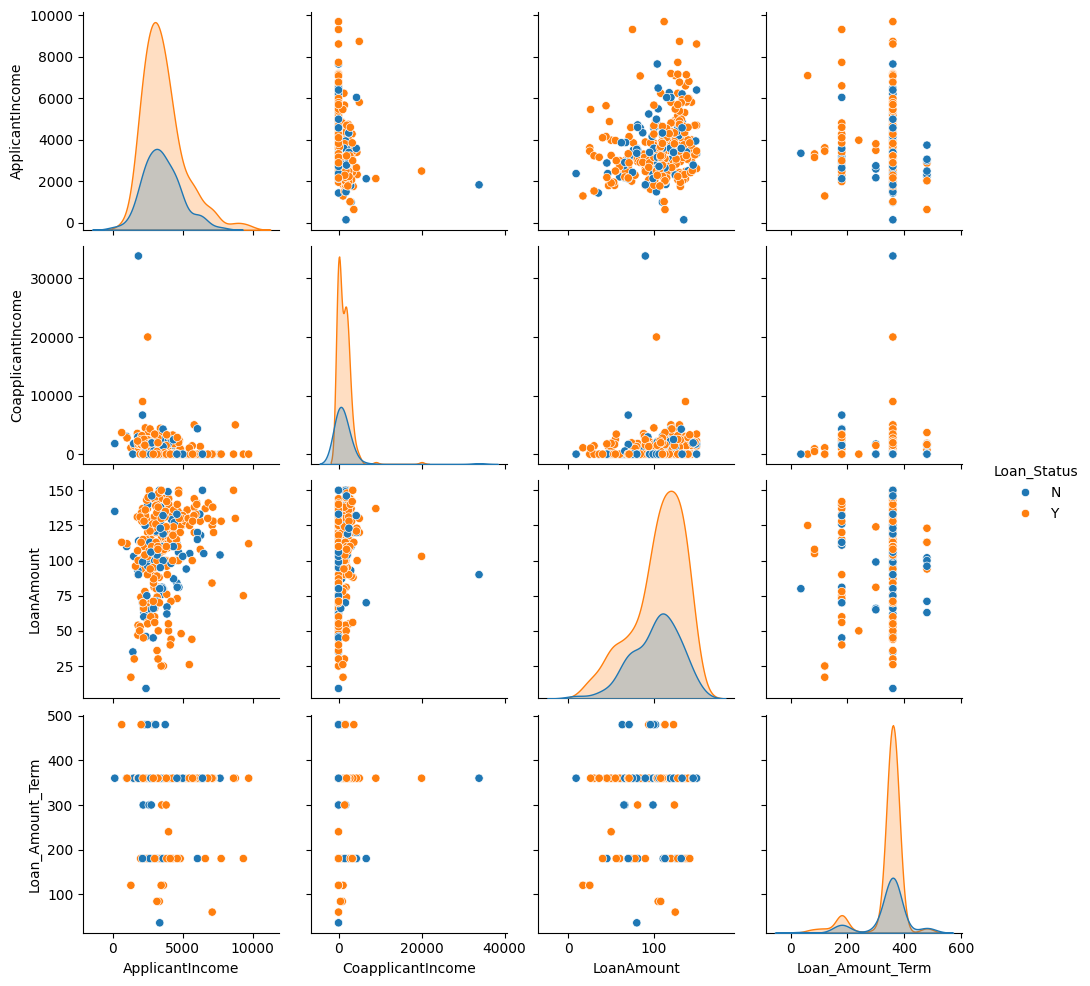

In [10]:
# Multivariate Analysis
# Pairplot for numerical variables
sns.pairplot(df[num_vars + ['Loan_Status']], hue='Loan_Status', diag_kind='kde')
plt.show()

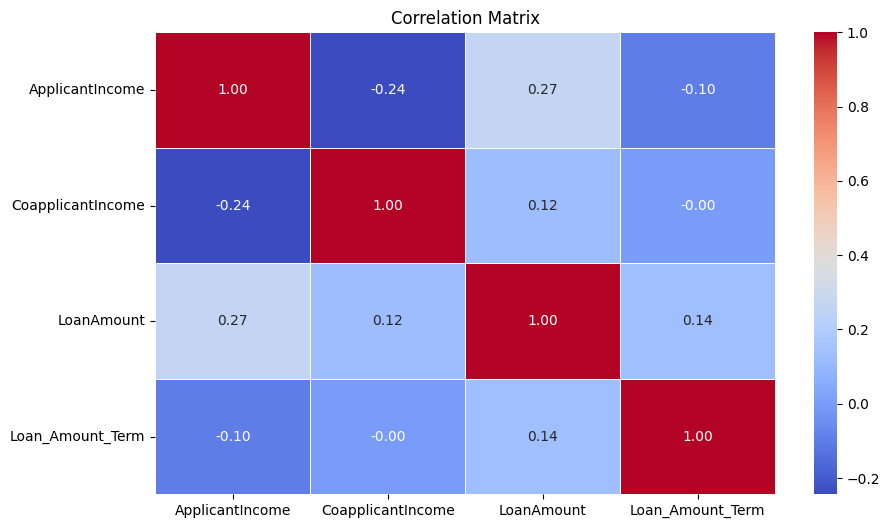

In [11]:
# Correlation Matrix
corr_matrix = df[num_vars].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

### Feature Engineering

In [12]:
# categorical variables to numerical using one-hot encoding
df_encoded = pd.get_dummies(df, columns=['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area'])

# scaling
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_encoded[['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']] = scaler.fit_transform(df_encoded[['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']])

# Feature Transformation
# ApplicantIncome + CoapplicantIncome = TotalIncome
df_encoded['TotalIncome'] = df_encoded['ApplicantIncome'] + df_encoded['CoapplicantIncome']

# Create a new feature for Debt-to-Income ratio
df_encoded['Debt_Income_Ratio'] = df_encoded['TotalIncome'] / (df_encoded['LoanAmount'] + 1)  # Adding 1 to avoid division by zero

# Drop unnecessary columns
df_final = df_encoded.drop(['Loan_ID', 'ApplicantIncome', 'CoapplicantIncome'], axis=1)

# Print the first few rows of the final dataset after feature engineering
print("Final Dataset after Feature Engineering:")
df_final.head()

Final Dataset after Feature Engineering:


,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Gender_Female,Gender_Male,Married_No,Married_Yes,Dependents_0,Dependents_1,...,Dependents_3+,Education_Graduate,Education_Not Graduate,Self_Employed_No,Self_Employed_Yes,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban,TotalIncome,Debt_Income_Ratio
0,0.843972,0.72973,1.0,N,False,True,False,True,False,True,...,False,True,False,True,False,True,False,False,0.508609,0.275823
1,0.404255,0.72973,1.0,Y,False,True,False,True,True,False,...,False,True,False,False,True,False,False,True,0.298336,0.212451
2,0.787234,0.72973,1.0,Y,False,True,False,True,True,False,...,False,False,True,True,False,False,False,True,0.324371,0.181494
3,0.936170,0.72973,1.0,Y,False,True,True,False,True,False,...,False,True,False,True,False,False,False,True,0.612373,0.316281
4,0.609929,0.72973,1.0,Y,False,True,False,True,True,False,...,False,False,True,True,False,False,False,True,0.273318,0.169770


### Decision Tree Model

In [13]:
# Split the data into features and target variable
X = df_final.drop('Loan_Status', axis=1)
y = df_final['Loan_Status']

# Split the data into train and test sets (80:20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Decision Tree classifier
dt_classifier = DecisionTreeClassifier(random_state=42)

# Train the classifier
dt_classifier.fit(X_train, y_train)

# Perform sample predictions
sample_predictions = dt_classifier.predict(X_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, sample_predictions))

Classification Report:
              precision    recall  f1-score   support

           N       0.50      0.55      0.52        20
           Y       0.78      0.74      0.76        42

    accuracy                           0.68        62
   macro avg       0.64      0.64      0.64        62
weighted avg       0.69      0.68      0.68        62



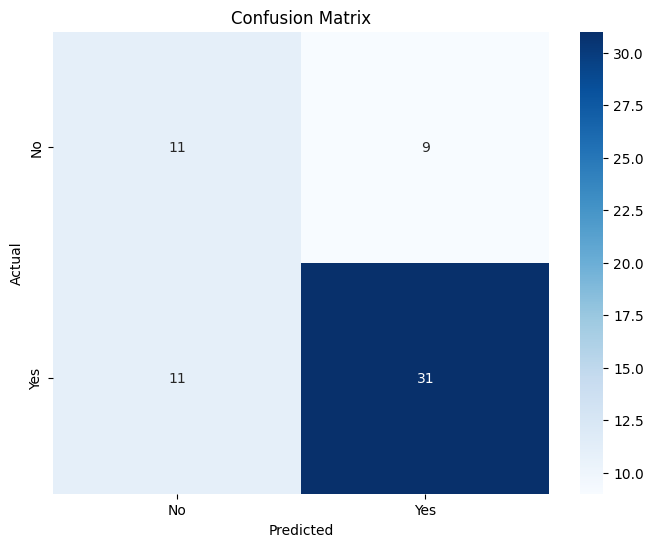

In [14]:
# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, sample_predictions)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [15]:
# Feature Importance
feature_importance = dt_classifier.feature_importances_

# Sort feature importances in descending order
sorted_indices = np.argsort(feature_importance)[::-1]
sorted_feature_importance = feature_importance[sorted_indices]
sorted_features = X.columns[sorted_indices]

# Print sorted feature importances
print("Sorted Feature Importances:")
for feature, importance in zip(sorted_features, sorted_feature_importance):
    print(f"{feature}: {importance}")


Sorted Feature Importances:
Credit_History: 0.36465677040889555
TotalIncome: 0.19589467908334007
Debt_Income_Ratio: 0.12603872251814816
LoanAmount: 0.09695986937754006
Loan_Amount_Term: 0.03261325487744054
Property_Area_Rural: 0.031220830262834672
Gender_Female: 0.029888828139238183
Married_Yes: 0.028236872915073798
Dependents_2: 0.026826109287421
Education_Graduate: 0.02148530254646688
Gender_Male: 0.017403801816011415
Property_Area_Semiurban: 0.01534664467604777
Dependents_1: 0.013428314091541797
Self_Employed_Yes: 0.0
Self_Employed_No: 0.0
Education_Not Graduate: 0.0
Dependents_3+: 0.0
Dependents_0: 0.0
Married_No: 0.0
Property_Area_Urban: 0.0


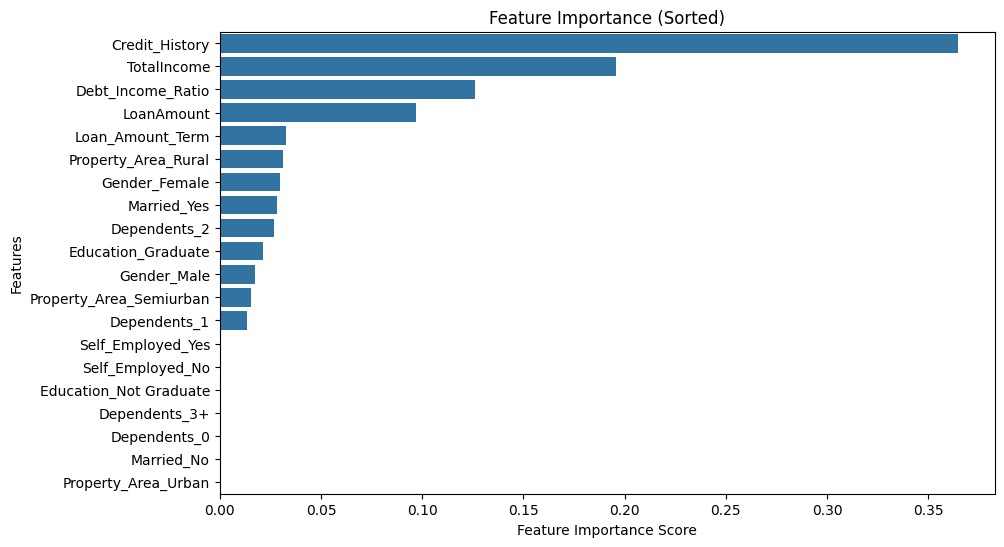

In [16]:

# Plot sorted feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x=sorted_feature_importance, y=sorted_features)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('Feature Importance (Sorted)')
plt.show()

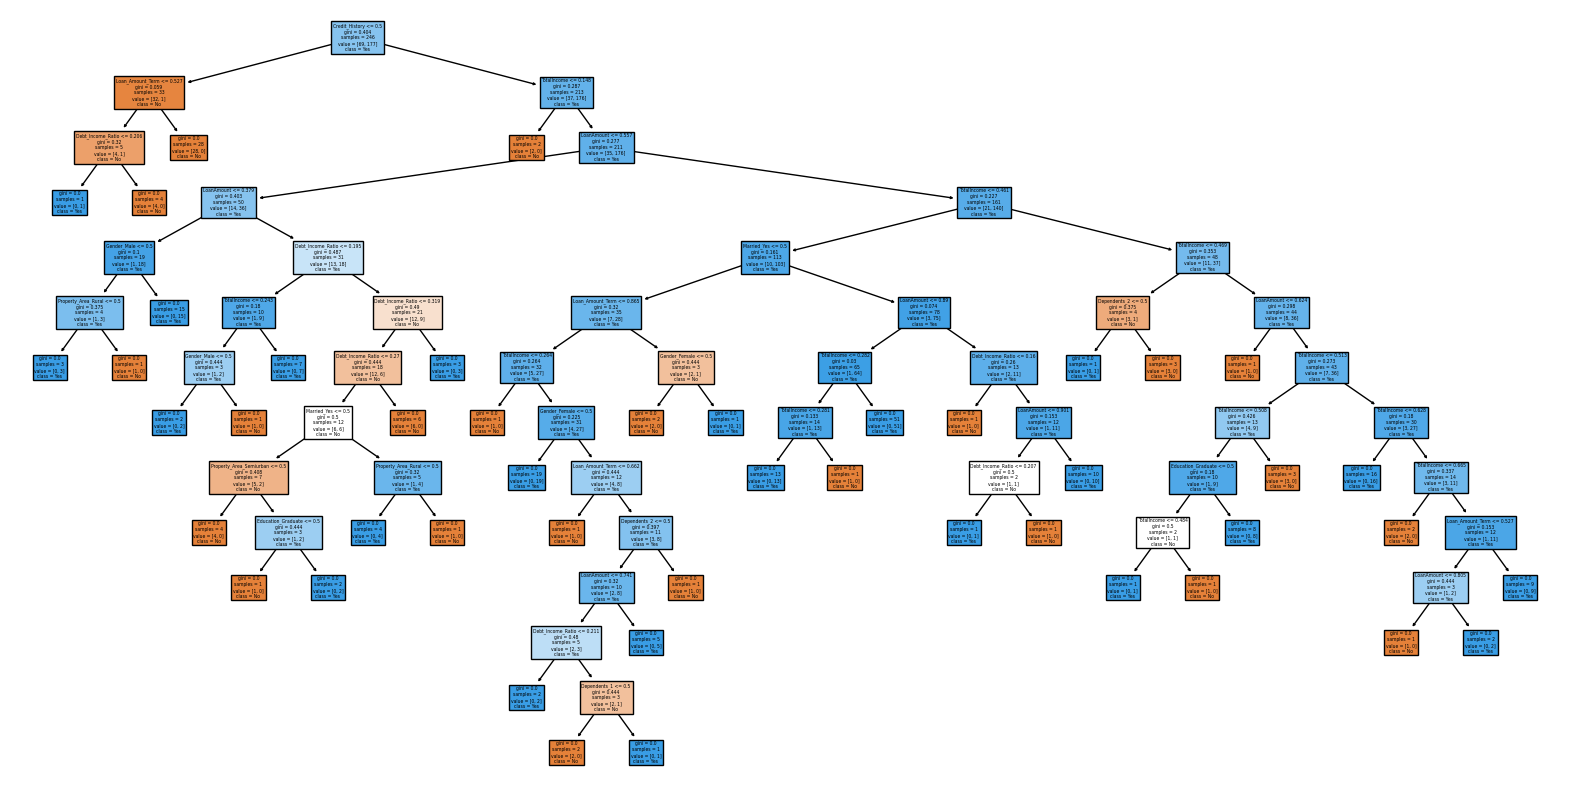

In [17]:
# Visualize the Decision Tree
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10))
plot_tree(dt_classifier, filled=True, feature_names=X.columns, class_names=['No', 'Yes'])
plt.show()

### Random Forest

In [18]:
# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Train the classifier
rf_classifier.fit(X_train, y_train)

# Perform sample predictions
sample_predictions = rf_classifier.predict(X_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, sample_predictions))

Classification Report:
              precision    recall  f1-score   support

           N       0.69      0.55      0.61        20
           Y       0.80      0.88      0.84        42

    accuracy                           0.77        62
   macro avg       0.75      0.72      0.73        62
weighted avg       0.77      0.77      0.77        62



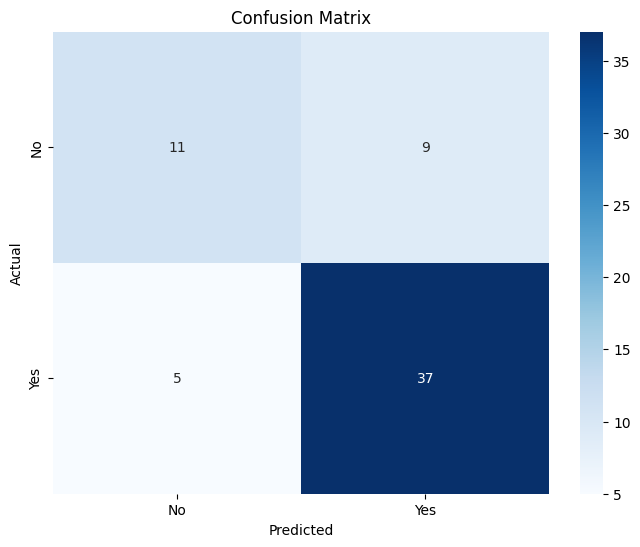

In [19]:
# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, sample_predictions)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [20]:
# Feature Importance for Random Forest
feature_importance_rf = rf_classifier.feature_importances_

# Sort feature importances in descending order
sorted_indices_rf = np.argsort(feature_importance_rf)[::-1]
sorted_feature_importance_rf = feature_importance_rf[sorted_indices_rf]
sorted_features_rf = X.columns[sorted_indices_rf]

# Print sorted feature importances
print("Sorted Feature Importances (Random Forest):")
for feature, importance in zip(sorted_features_rf, sorted_feature_importance_rf):
    print(f"{feature}: {importance}")


Sorted Feature Importances (Random Forest):
Credit_History: 0.2653957982561561
Debt_Income_Ratio: 0.16032215846475162
TotalIncome: 0.15418202451925084
LoanAmount: 0.13415884432528183
Loan_Amount_Term: 0.055376881138168875
Property_Area_Rural: 0.023975943417668254
Property_Area_Semiurban: 0.023200517572341116
Property_Area_Urban: 0.020568960767336456
Married_Yes: 0.02017904608737865
Dependents_0: 0.01603412068350637
Married_No: 0.015748713637693607
Gender_Female: 0.01550193506073751
Gender_Male: 0.01506144606213343
Dependents_1: 0.0132572637993707
Education_Not Graduate: 0.012832656979975782
Self_Employed_Yes: 0.012087177039450375
Education_Graduate: 0.012073077547348843
Dependents_2: 0.011662385205741612
Self_Employed_No: 0.01008213497633665
Dependents_3+: 0.0082989144593712


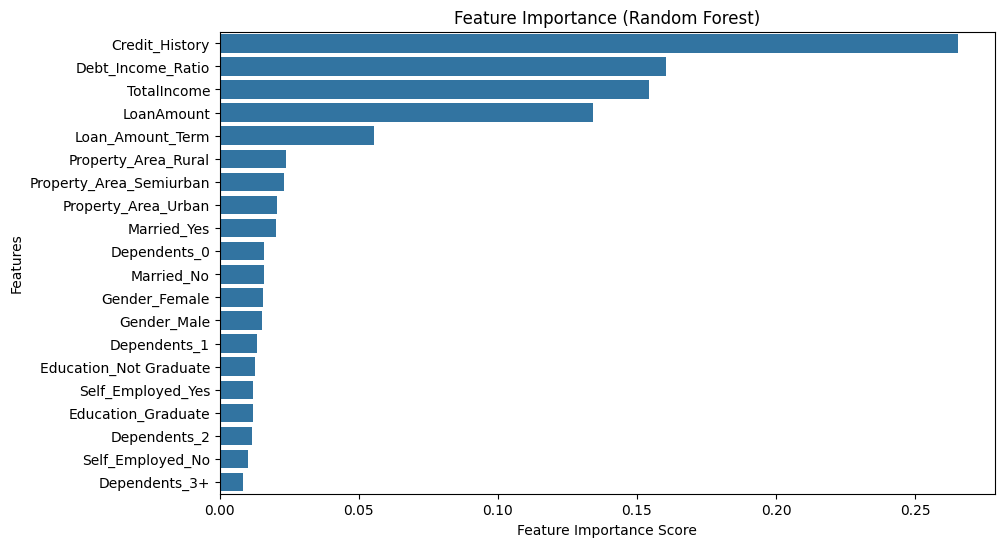

In [21]:
# Plot sorted feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x=sorted_feature_importance_rf, y=sorted_features_rf)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('Feature Importance (Random Forest)')
plt.show()

### Support Vector Machine (SVM)

In [22]:
# Initialize the SVM classifier
svm_classifier = SVC(random_state=42)

# Train the classifier
svm_classifier.fit(X_train, y_train)

# Perform sample predictions
sample_predictions = svm_classifier.predict(X_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, sample_predictions))

Classification Report:
              precision    recall  f1-score   support

           N       0.83      0.50      0.62        20
           Y       0.80      0.95      0.87        42

    accuracy                           0.81        62
   macro avg       0.82      0.73      0.75        62
weighted avg       0.81      0.81      0.79        62



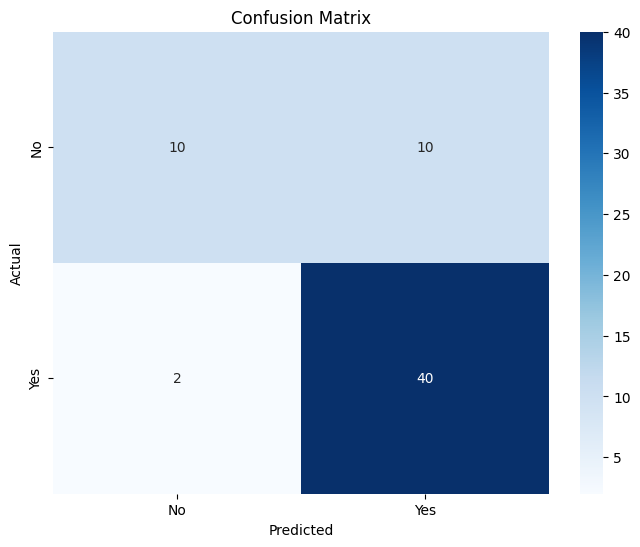

In [23]:
# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, sample_predictions)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [24]:
# Get feature importances for linear SVM
if svm_classifier.kernel == 'linear':
    feature_importance = svm_classifier.coef_[0]
    abs_feature_importance = abs(feature_importance)
    sorted_indices = abs_feature_importance.argsort()[::-1]

    # Visualize feature importances
    plt.figure(figsize=(10, 6))
    sns.barplot(x=feature_importance[sorted_indices], y=X.columns[sorted_indices])
    plt.xlabel('Feature Importance Score')
    plt.ylabel('Features')
    plt.title('Feature Importance for Linear SVM')
    plt.show()
else:
    print("Feature importances can only be analyzed for linear SVM models.")

Feature importances can only be analyzed for linear SVM models.


### Naive Bayes Classifier

In [25]:
# Initialize the Naive Bayes classifier
nb_classifier = GaussianNB()

# Train the classifier
nb_classifier.fit(X_train, y_train)

# Perform sample predictions
sample_predictions = nb_classifier.predict(X_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, sample_predictions))

Classification Report:
              precision    recall  f1-score   support

           N       0.59      0.50      0.54        20
           Y       0.78      0.83      0.80        42

    accuracy                           0.73        62
   macro avg       0.68      0.67      0.67        62
weighted avg       0.72      0.73      0.72        62



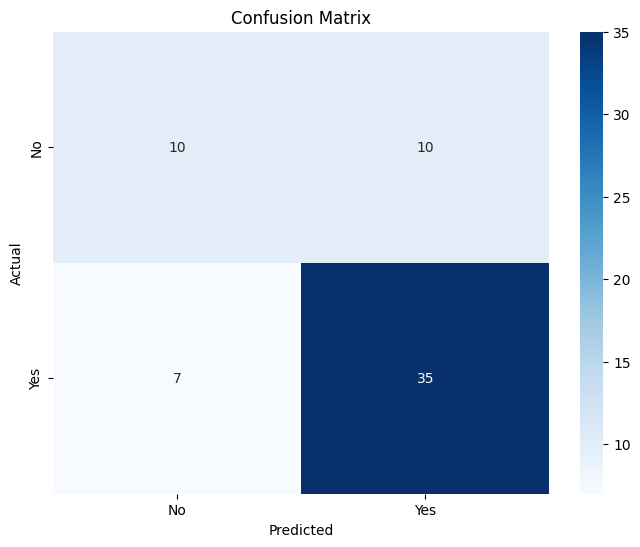

In [26]:
# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, sample_predictions)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### Overall Models Evaluation

In [27]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

# Encode the target variable 'Loan_Status'
le = LabelEncoder()
y_test_encoded = le.fit_transform(y_test)

# Define lists to store performance scores
models = ['Decision Tree', 'Random Forest', 'Support Vector Machine', 'Naive Bayes']
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
roc_auc_scores = []
colors = ['blue', 'green', 'orange', 'red']

# Function to calculate and append performance scores
def calculate_scores(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_encoded = le.transform(y_pred)  # Encode the predicted labels
    accuracy_scores.append(accuracy_score(y_test, y_pred_encoded))
    precision_scores.append(precision_score(y_test, y_pred_encoded, average='weighted'))
    recall_scores.append(recall_score(y_test, y_pred_encoded, average='weighted'))
    f1_scores.append(f1_score(y_test, y_pred_encoded, average='weighted'))
    roc_auc_scores.append(roc_auc_score(y_test, y_pred_encoded))

# Calculate performance scores for each model
calculate_scores(dt_classifier, X_test, y_test_encoded)
calculate_scores(rf_classifier, X_test, y_test_encoded)
calculate_scores(svm_classifier, X_test, y_test_encoded)
calculate_scores(nb_classifier, X_test, y_test_encoded)

# Print evaluation metrics for each model
for model, accuracy, precision, recall, f1, roc_auc in zip(models, accuracy_scores, precision_scores, recall_scores, f1_scores, roc_auc_scores):
    print(f"Model: {model}")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-Score: {f1:.2f}")
    print(f"ROC-AUC: {roc_auc:.2f}")
    print()


Model: Decision Tree
Accuracy: 0.68
Precision: 0.69
Recall: 0.68
F1-Score: 0.68
ROC-AUC: 0.64

Model: Random Forest
Accuracy: 0.77
Precision: 0.77
Recall: 0.77
F1-Score: 0.77
ROC-AUC: 0.72

Model: Support Vector Machine
Accuracy: 0.81
Precision: 0.81
Recall: 0.81
F1-Score: 0.79
ROC-AUC: 0.73

Model: Naive Bayes
Accuracy: 0.73
Precision: 0.72
Recall: 0.73
F1-Score: 0.72
ROC-AUC: 0.67



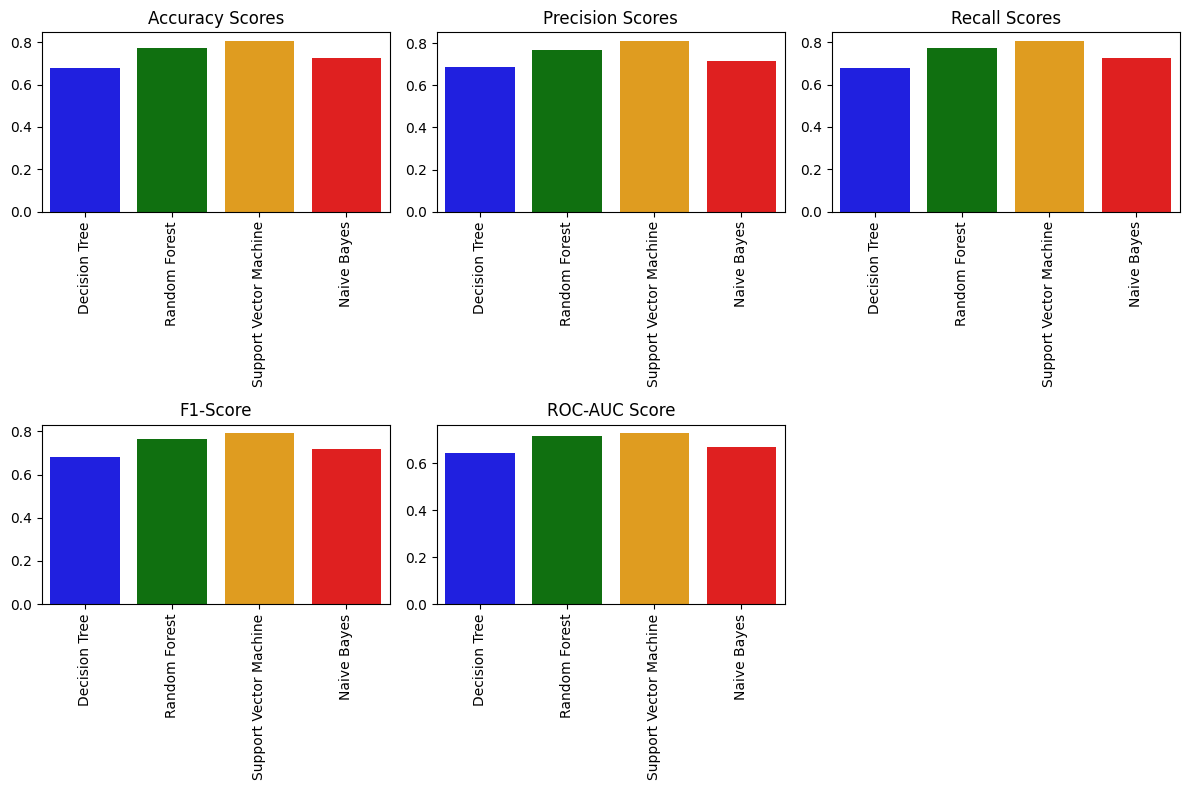

In [28]:
# Plotting performance scores
plt.figure(figsize=(12, 8))

# Accuracy
plt.subplot(2, 3, 1)
sns.barplot(x=models, y=accuracy_scores, palette=colors)
plt.xticks(rotation=90)
plt.title('Accuracy Scores')

# Precision
plt.subplot(2, 3, 2)
sns.barplot(x=models, y=precision_scores, palette=colors)
plt.xticks(rotation=90)
plt.title('Precision Scores')

# Recall
plt.subplot(2, 3, 3)
sns.barplot(x=models, y=recall_scores, palette=colors)
plt.xticks(rotation=90)
plt.title('Recall Scores')

# F1-Score
plt.subplot(2, 3, 4)
sns.barplot(x=models, y=f1_scores, palette=colors)
plt.xticks(rotation=90)
plt.title('F1-Score')

# ROC-AUC Score
plt.subplot(2, 3, 5)
sns.barplot(x=models, y=roc_auc_scores, palette=colors)
plt.xticks(rotation=90)
plt.title('ROC-AUC Score')

plt.tight_layout()
plt.show()

### Export Models

In [29]:
import joblib
import numpy as np

# Step 1: Save all models
joblib.dump(dt_classifier, 'decision_tree_model.pkl')
joblib.dump(rf_classifier, 'random_forest_model.pkl')
joblib.dump(svm_classifier, 'svm_model.pkl')
joblib.dump(nb_classifier, 'naive_bayes_model.pkl')

['naive_bayes_model.pkl']

### Sample Test Predictions

In [30]:
import joblib
import numpy as np

# load the models that were trained and saved
dt_model = joblib.load('decision_tree_model.pkl')
rf_model = joblib.load('random_forest_model.pkl')
svm_model = joblib.load('svm_model.pkl')
nb_model = joblib.load('naive_bayes_model.pkl')

# generic func to get user input
def get_user_input(feature_name, feature_type, default_value):
    if feature_type == 'categorical':
        allowed_values = ', '.join(default_value)
        value = input(f"Enter value for {feature_name} ({allowed_values}): ").strip().lower()
        if value in default_value:
            return value
        else:
            print(f"Invalid input! Please select from {allowed_values}")
            return get_user_input(feature_name, feature_type, default_value)
    elif feature_type == 'numeric':
        value = input(f"Enter value for {feature_name} (default: {default_value}): ").strip()
        if value == '':
            return default_value
        try:
            return float(value)
        except ValueError:
            print("Invalid input! Please enter a numeric value.")
            return get_user_input(feature_name, feature_type, default_value)


sample_input = {}
for feature_info in [('LoanAmount', 'numeric', 150),
                     ('Loan_Amount_Term', 'numeric', 360),
                     ('Credit_History', 'categorical', ['1', '0']),
                     ('Gender', 'categorical', ['male', 'female']),
                     ('Married', 'categorical', ['yes', 'no']),
                     ('Dependents', 'categorical', ['0', '1', '2', '3+']),
                     ('Education', 'categorical', ['graduate', 'not graduate']),
                     ('Self_Employed', 'categorical', ['yes', 'no']),
                     ('Property_Area', 'categorical', ['urban', 'semiurban', 'rural']),
                     ('ApplicantIncome', 'numeric', 5000),
                     ('CoapplicantIncome', 'numeric', 0)]:
    sample_input[feature_info[0]] = get_user_input(*feature_info)

# Eencode categorical featrues
sample_input_encoded = {
    'Gender_Female': 1 if sample_input['Gender'] == 'female' else 0,
    'Gender_Male': 1 if sample_input['Gender'] == 'male' else 0,
    'Married_No': 1 if sample_input['Married'] == 'no' else 0,
    'Married_Yes': 1 if sample_input['Married'] == 'yes' else 0,
    'Dependents_0': 1 if sample_input['Dependents'] == '0' else 0,
    'Dependents_1': 1 if sample_input['Dependents'] == '1' else 0,
    'Dependents_2': 1 if sample_input['Dependents'] == '2' else 0,
    'Dependents_3+': 1 if sample_input['Dependents'] == '3+' else 0,
    'Education_Graduate': 1 if sample_input['Education'] == 'graduate' else 0,
    'Education_Not Graduate': 1 if sample_input['Education'] == 'not graduate' else 0,
    'Self_Employed_No': 1 if sample_input['Self_Employed'] == 'no' else 0,
    'Self_Employed_Yes': 1 if sample_input['Self_Employed'] == 'yes' else 0,
    'Property_Area_Rural': 1 if sample_input['Property_Area'] == 'rural' else 0,
    'Property_Area_Semiurban': 1 if sample_input['Property_Area'] == 'semiurban' else 0,
    'Property_Area_Urban': 1 if sample_input['Property_Area'] == 'urban' else 0,
    'ApplicantIncome': float(sample_input['ApplicantIncome']),
    'CoapplicantIncome': float(sample_input['CoapplicantIncome'])
}

#  additional features calculation
sample_input_encoded['LoanAmount'] = sample_input['LoanAmount']
sample_input_encoded['Loan_Amount_Term'] = sample_input['Loan_Amount_Term']
sample_input_encoded['Credit_History'] = float(sample_input['Credit_History'])
sample_input_encoded['TotalIncome'] = sample_input_encoded['ApplicantIncome'] + sample_input_encoded['CoapplicantIncome']
sample_input_encoded['Debt_Income_Ratio'] = sample_input['LoanAmount'] / sample_input_encoded['TotalIncome']

# Convert input to numpy array for prediction
sample_data = np.array([[sample_input_encoded[feature] for feature in ['LoanAmount', 'Loan_Amount_Term', 'Credit_History', 'Gender_Female', 'Gender_Male', 'Married_No', 'Married_Yes', 'Dependents_0', 'Dependents_1', 'Dependents_2', 'Dependents_3+', 'Education_Graduate', 'Education_Not Graduate', 'Self_Employed_No', 'Self_Employed_Yes', 'Property_Area_Rural', 'Property_Area_Semiurban', 'Property_Area_Urban', 'TotalIncome', 'Debt_Income_Ratio']]])

# predict using all the models
dt_prediction = dt_model.predict(sample_data)[0]
rf_prediction = rf_model.predict(sample_data)[0]
svm_prediction = svm_model.predict(sample_data)[0]
nb_prediction = nb_model.predict(sample_data)[0]

# convert predictoin to better human readable format
def get_approval_status(prediction):
    return "Approved" if prediction == 'Y' else "Not Approved"

# print predictions
print("Decision Tree prediction:", get_approval_status(dt_prediction))
print("Random Forest prediction:", get_approval_status(rf_prediction))
print("Support Vector Machine prediction:", get_approval_status(svm_prediction))
print("Naive Bayes prediction:", get_approval_status(nb_prediction))


Enter value for LoanAmount (default: 150): 5000
Enter value for Loan_Amount_Term (default: 360): 240
Enter value for Credit_History (1, 0): 0
Enter value for Gender (male, female): female
Enter value for Married (yes, no): yes
Enter value for Dependents (0, 1, 2, 3+): 3+
Enter value for Education (graduate, not graduate): graduate
Enter value for Self_Employed (yes, no): yes
Enter value for Property_Area (urban, semiurban, rural): semiurban
Enter value for ApplicantIncome (default: 5000): 2500
Enter value for CoapplicantIncome (default: 0): 0
Decision Tree prediction: Not Approved
Random Forest prediction: Not Approved
Support Vector Machine prediction: Approved
Naive Bayes prediction: Approved
